In [1]:
%load_ext autoreload
%autoreload 2

import numpy  as np
import pandas as pd
import h5py

from scipy.interpolate import interp1d

from matplotlib import pyplot as plt

from common import hallmark as hm

## Load simulation data from cache

In [2]:
pf = hm.ParaFrame('cache/Illinois_thermal_w{win:d}/{mag}a{aspin:g}_i{inc:d}/sed_Rh{Rhigh:d}.h5')

for k in set(pf.keys()) - {'path'}:
    globals()[k] = np.unique(pf[k])
    print(k, globals()[k][:16])

aspin [-0.94 -0.5   0.    0.5   0.94]
inc [ 10  30  50  70  90 110 130 150 170]
Rhigh [  1  10  40 160]
win [3 4 5]
mag ['M' 'S']


In [3]:
def readsed(f):
    with h5py.File(f) as h:
        time = h['time'][:]
        nu   = h['nu'  ][:]
        knd  = h['knd' ][:]
        avg  = h['avg' ][:]
        rlz  = h['len' ][:]
        
    if not all(rlz == 16):
        print('WARNING: less than 16 realizations:', f)
        
    return nu, np.mean(avg[:,:,:],axis=0), knd

freqs = [86e9, 230e9, 1.4141e+14, 1.45e18]

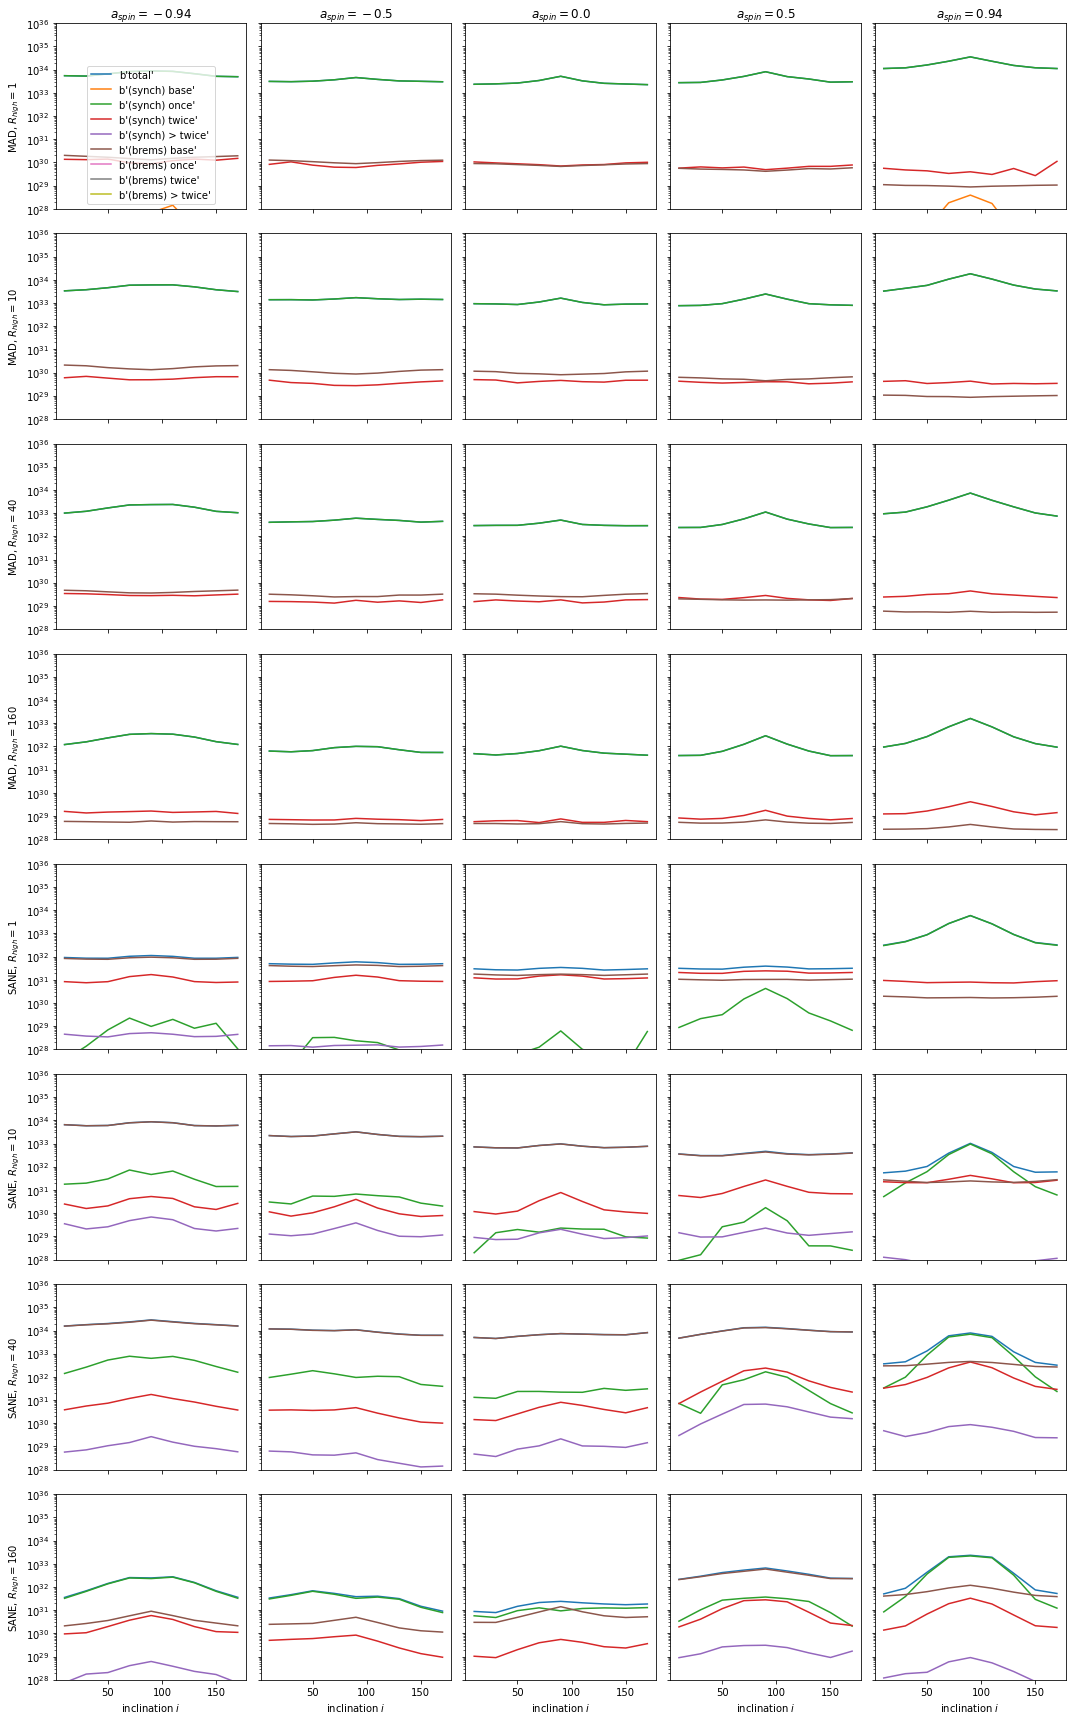

In [24]:
fig, axes = plt.subplots(8, 5, figsize=(15,24), sharex=True, sharey=True)

for c, a in enumerate(aspin):
    for r1, m in enumerate(mag):
        for r2, Rh in enumerate(Rhigh):
            #print(a, m, Rh)
            r = r1 * 4 + r2

            sel = pf(aspin=a)(mag=m)(Rhigh=Rh)(win=5)
            
            flux_86GHz  = []
            flux_230GHz = []
            flux_NIR    = []
            flux_xray   = []
            for i in inc:
                nu, avg, knd = readsed(sel(inc=i).path.iloc[0])

                res = np.array([
                    interp1d(nu, avg[:,i])(freqs)
                    for i, k in enumerate(knd)
                ])
                flux_86GHz .append(res[:,0])
                flux_230GHz.append(res[:,1])
                flux_NIR   .append(res[:,2])
                flux_xray  .append(res[:,3])
                
            flux_86GHz  = np.array(flux_86GHz)
            flux_230GHz = np.array(flux_230GHz)
            flux_NIR    = np.array(flux_NIR)
            flux_xray   = np.array(flux_xray)
            
            axes[r][c].semilogy(inc, flux_xray, label=knd)

            if r == 0:
                axes[r][c].set_title(f'$a_{{spin}} = {a}$')
            elif r == 7:
                axes[r][c].set_xlabel('inclination $i$')
            if c == 0:
                axes[r][c].set_ylabel(f'{"MAD" if m == "M" else "SANE"}, $R_{{high}} = {Rh}$')

            axes[r][c].set_ylim([1e28,1e36])

axes[0][0].legend()
fig.tight_layout()
fig.savefig(f'output/sed_phys_xray.pdf')
fig.savefig(f'output/sed_phys_xray.png', dpi=300)